In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path("..")                  
DATA = ROOT / "StudentProjectData"
RESULTS = ROOT / "results"
RESULTS.mkdir(exist_ok=True)

 Loader Utilities

In [2]:
# %%
def load_txt_matrix(path):
    """
    Loads a text file into a NumPy array.
    If the first line contains commas, treat it as CSV.
    Else treat as whitespace-separated text.
    """
    text = open(path).read()
    if "," in text.splitlines()[0]:
        return np.loadtxt(path, delimiter=",")
    return np.loadtxt(path)

def load_classification(i):
    """
    Load TrainData{i}, TrainLabel{i}, TestData{i}.
    Returns:
        X_train : (n_train, d)
        y_train : (n_train,)
        X_test  : (n_test, d)
    """
    X_train = load_txt_matrix(DATA / f"TrainData{i}.txt")
    y_train = load_txt_matrix(DATA / f"TrainLabel{i}.txt")
    X_test  = load_txt_matrix(DATA / f"TestData{i}.txt")
    return X_train, y_train.astype(int), X_test

Missing Value Handling (direct reuse from 02_missing_value.ipynb)

In [3]:
# %%
MISSING_MARKER = 1e99

def replace_missing_marker(X, marker=MISSING_MARKER):
    """
    Replace the 1e99 placeholder with np.nan for proper missing-value handling.
    """
    X = X.astype(float).copy()
    X[X == marker] = np.nan
    return X

In [4]:
print("Checking missing values in classification datasets (1e99 marker)...\n")
for i in range(1, 5):
    X_train, y_train, X_test = load_classification(i)
    
    train_missing = np.sum(X_train == MISSING_MARKER)
    test_missing  = np.sum(X_test  == MISSING_MARKER)

    print(f"Dataset {i}:")
    print(f"   Train missing values: {train_missing}")
    print(f"   Test missing values : {test_missing}\n")

Checking missing values in classification datasets (1e99 marker)...

Dataset 1:
   Train missing values: 9936
   Test missing values : 7021

Dataset 2:
   Train missing values: 0
   Test missing values : 0

Dataset 3:
   Train missing values: 1886
   Test missing values : 0

Dataset 4:
   Train missing values: 0
   Test missing values : 0



KNN Imputation

In [5]:
def knn_impute(X, k):
    """
    KNN Imputation for missing values (np.nan) in a 2D NumPy matrix.

    PARAMETERS:
        X : 2D numpy array, shape (num_rows, num_features)
            Contains real numbers and np.nan marking missing entries.

        k : int
            Number of neighbors to use for imputation.

    RETURNS:
        X_filled : 2D numpy array of same shape as X
            All np.nan replaced via KNN or column-mean fallback.
    """
    # 1. Create a copy of the original array:
    X_filled = X.copy()
    
    # 2. Identify which rows contain missing values
    #    This avoids scanning full rows multiple times unnecessarily.
    row_has_missing = np.isnan(X_filled).any(axis=1)
    
    # 3. Loop over rows
     # 3. Loop through each row (each sample)
    for i in range(X_filled.shape[0]):

        # If row i has no missing values → skip it
        if not row_has_missing[i]:
            continue

        # Extract the row vector
        row = X_filled[i]

        # Boolean masks: which features in this row are missing or valid
        missing_mask = np.isnan(row)      # True where row[i,f] is nan
        valid_mask   = ~missing_mask      # True where row[i,f] is known

        # If the row has *no valid features* at all (very rare),
        # we CANNOT compute distances with any neighbor.
        if valid_mask.sum() == 0:
            # Fallback: fill *every* missing feature with global column mean
            missing_cols = np.where(missing_mask)[0]
            for c in missing_cols:
                col_vals = X_filled[:, c]
                X_filled[i, c] = np.nanmean(col_vals)
            continue
        
        # 3.1 Build candidate neighbors:
        # rows that do NOT have missing values in valid features and are not i
        candidate_indices = []
        for j in range(X_filled.shape[0]):
            if j == i:
                continue  # skip itself

            other = X_filled[j]

            # We require that the neighbor row has NO missing values
            # in the "valid" dimensions of this row.
            # If it has missing in those dims → we CANNOT compare on equal footing.
            if np.isnan(other[valid_mask]).any():
                continue

            candidate_indices.append(j)
        
        # IF NO CANDIDATES EXIST → COLUMN MEAN FALLBACK
        if len(candidate_indices) == 0:
            # Identify missing columns for row i
            missing_cols = np.where(missing_mask)[0]

            # For each missing feature, fill using global column mean
            for c in missing_cols:
                col_vals = X_filled[:, c]
                col_mean = np.nanmean(col_vals)
                X_filled[i, c] = col_mean

            continue  # finished imputing row i; move to next row
        
        # 3.2 Compute distances vectorized over candidates
        # shape: (num_candidates, num_valid_features)
        # Extract only rows of candidate neighbors
        # but keep *only valid features* for distance computation
        candidate_matrix = X_filled[candidate_indices][:, valid_mask]
        
        # Target vector = row i, but only valid dims
        target_vector = row[valid_mask]
        
        # Compute differences between ALL candidates and the target
        diffs = candidate_matrix - target_vector  # broadcasting
        
        # Euclidean distance along feature axis
        dists = np.linalg.norm(diffs, axis=1)
        
        # 3.3 Choose up to k nearest neighbors
        order = np.argsort(dists)               # sorted by distance
        k_eff = min(k, len(order))              # handle case k > available neighbors
        local_neighbor_indices = order[:k_eff]  # local positions in candidate list
        
        # Convert local candidate positions → actual row indices
        neighbor_indices = [candidate_indices[idx] for idx in local_neighbor_indices]

        
        # 3.4 Impute each missing feature
        missing_cols = np.where(missing_mask)[0]
        
        for c in missing_cols:
            vals = []
            
            # Collect each neighbor's value in this column
            for ni in neighbor_indices:
                v = X_filled[ni, c]
                if not np.isnan(v):
                    vals.append(v)
            
            # Convert vals to array
            vals = np.array(vals)
            
            # Case 1: All neighbors have nan in this column → fallback again
            if vals.size == 0:
                 # fallback: global column mean for feature c
                col_vals = X_filled[:, c]
                col_mean = np.nanmean(col_vals)
                X_filled[i, c] = col_mean
                
            # Case 2: Normal case → average neighbor values
            else:
                X_filled[i, c] = np.mean(vals)
                
    return X_filled        
            

Helper Functions for Imputation K-selection (RMSE)

In [6]:
# ### 2.2 K-selection for Imputation (RMSE vs K)
# 
# We follow the same idea as in 02_missing_value.ipynb:
# - Work only on the *training* matrix X_train for a dataset.
# - Find rows with no missing values ("complete rows").
# - Hide a random subset of observed entries from those rows.
# - Impute the hidden values using different K.
# - Compare imputed values with original values → RMSE.
# - Choose the K with smallest RMSE.

# %%
def get_complete_rows(X):
    """
    Return indices of rows that contain NO missing values.
    """
    return np.where(~np.isnan(X).any(axis=1))[0]

def mask_from_complete_rows(X, complete_rows, fraction=0.05, seed=0):
    """
    Hide a fraction of observed entries ONLY in the complete rows.
    Returns:
        X_masked         : copy of X with some entries set to np.nan
        hidden_positions : list of (row, col) indices of hidden entries
    """
    rng = np.random.default_rng(seed)

    # All observed positions (non-NaN) in X
    observed = np.argwhere(~np.isnan(X))

    # Filter to only positions in complete rows
    observed = np.array([pos for pos in observed if pos[0] in complete_rows])

    # Number of positions to hide
    n_hide = int(len(observed) * fraction)
    chosen = rng.choice(len(observed), n_hide, replace=False)
    hidden_positions = observed[chosen]

    # Create masked copy
    X_masked = X.copy()
    for r, c in hidden_positions:
        X_masked[r, c] = np.nan

    return X_masked, hidden_positions

def evaluate_imputation_k(X, k, fraction=0.05, seed=0):
    """
    Evaluate K for imputation:
    - Works on matrix X (with NaNs).
    - Restrict hiding to rows that are fully observed.
    - Mask some known entries.
    - Impute with knn_impute using this K.
    - Compute RMSE on the hidden entries.
    """
    complete_rows = get_complete_rows(X)
    if len(complete_rows) == 0:
        # No complete rows → cannot evaluate; return big error
        return np.inf

    X_masked, hidden_positions = mask_from_complete_rows(
        X, complete_rows, fraction=fraction, seed=seed
    )

    X_imputed = knn_impute(X_masked, k=k)

    # Collect squared errors at hidden positions
    sq_errors = []
    for r, c in hidden_positions:
        true_val = X[r, c]
        pred_val = X_imputed[r, c]
        sq_errors.append((true_val - pred_val) ** 2)

    return np.sqrt(np.mean(sq_errors))

Imputation K-selection for Datasets 1 and 4


Imputation K-selection for Dataset 1


  K=1, RMSE=inf
  K=2, RMSE=inf
  K=3, RMSE=inf
  K=4, RMSE=inf
  K=5, RMSE=inf
  K=6, RMSE=inf
  K=7, RMSE=inf
  K=8, RMSE=inf
  K=9, RMSE=inf
  K=10, RMSE=inf


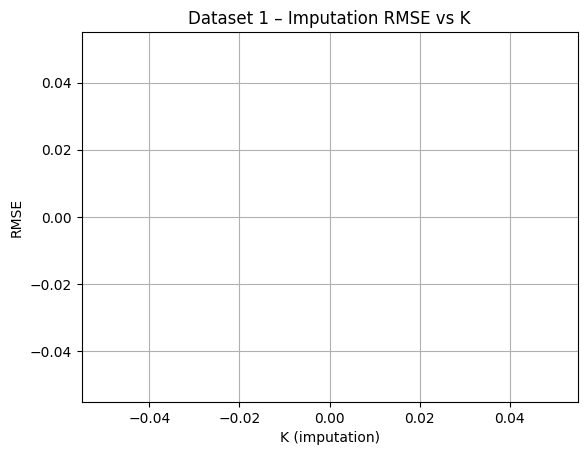

Best K_impute for Dataset 1 = 1

Imputation K-selection for Dataset 3
  K=1, RMSE=1.4254
  K=2, RMSE=1.2569
  K=3, RMSE=1.1809
  K=4, RMSE=1.1545
  K=5, RMSE=1.1199
  K=6, RMSE=1.1206
  K=7, RMSE=1.1039
  K=8, RMSE=1.1084
  K=9, RMSE=1.1072
  K=10, RMSE=1.1029


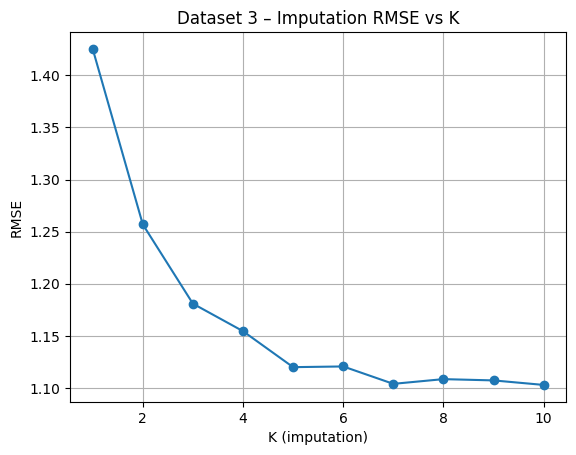

Best K_impute for Dataset 3 = 10


{1: 1, 3: 10}

In [7]:
# ### 2.3 Imputation K-selection for Dataset 1 and 3
# 
# Dataset 1 and 3 have missing values.
# We:
# - Use only the *training* matrix.
# - Convert 1e99 → NaN.
# - Evaluate K from 1 to 10.
# - Plot RMSE vs K.
# - Choose the K with smallest RMSE.

# %%
imputation_k_results = {}

for i in (1, 3):
    print("\n" + "="*40)
    print(f"Imputation K-selection for Dataset {i}")
    X_train_raw, y_train_raw, _ = load_classification(i)
    X_train_nan = replace_missing_marker(X_train_raw)

    Ks = list(range(1, 11))  # 1..10
    rmses = []

    for k in Ks:
        rmse = evaluate_imputation_k(X_train_nan, k=k, fraction=0.05, seed=42)
        rmses.append(rmse)
        print(f"  K={k}, RMSE={rmse:.4f}")

    # Plot RMSE vs K
    plt.figure()
    plt.plot(Ks, rmses, marker='o')
    plt.title(f"Dataset {i} – Imputation RMSE vs K")
    plt.xlabel("K (imputation)")
    plt.ylabel("RMSE")
    plt.grid(True)
    plt.show()

    # Choose best K (smallest RMSE)
    best_k = Ks[int(np.argmin(rmses))]
    imputation_k_results[i] = best_k
    print(f"Best K_impute for Dataset {i} = {best_k}")

imputation_k_results

In [8]:
# %%
def impute_dataset(X_train, X_test, k_impute=None):
    """
    Replace 1e99 → np.nan, then impute train and test.
    If k_impute is None: use simple column-mean imputation.
    Else: use KNN imputation with k_impute neighbors.
    """
    X_train = replace_missing_marker(X_train)
    X_test  = replace_missing_marker(X_test)

    if k_impute is None:
        col_means = np.nanmean(X_train, axis=0)

        def fill_mean(X):
            X_filled = X.copy()
            inds = np.where(np.isnan(X_filled))
            X_filled[inds] = np.take(col_means, inds[1])
            return X_filled

        return fill_mean(X_train), fill_mean(X_test)

    # KNN imputation
    return knn_impute(X_train, k_impute), knn_impute(X_test, k_impute)

Standardization (Training → Test)

In [9]:
# %%
def compute_standardization_params(X):
    mean = np.nanmean(X, axis=0)
    std  = np.nanstd(X, axis=0)
    std[std == 0] = 1.0
    return mean, std

def apply_standardization(X, mean, std):
    return (X - mean) / std

Full Preprocess Function Per Dataset

The Workflow: 

*  Load → replace missing marker → impute → standardize.

In [14]:
def preprocess_dataset(i, imputation_k_dict):
    """
    Preprocess a classification dataset:
      1. Load data
      2. Replace 1e99 → NaN
      3. Impute (mean or KNN)
      4. Standardize using training stats
      5. Convert labels to zero-based for ML models
    """

    # Load
    X_train_raw, y_train, X_test_raw = load_classification(i)

    # Convert labels to zero-based indexing
    unique_labels = np.unique(y_train)
    label_map = {old: new for new, old in enumerate(unique_labels)}
    y_train = np.array([label_map[label] for label in y_train])

    # Pick K for imputation
    k_impute = imputation_k_dict.get(i, None)

    # Impute
    X_train_imp, X_test_imp = impute_dataset(
        X_train_raw, X_test_raw, k_impute=k_impute
    )

    # Standardize
    mean, std = compute_standardization_params(X_train_imp)
    X_train_std = apply_standardization(X_train_imp, mean, std)
    X_test_std  = apply_standardization(X_test_imp,  mean, std)

    return X_train_std, y_train.astype(int), X_test_std

---
#### CLASSIFICATION ALGORITHMS BEGIN:
---

---
#### 1 hidden layer NN CLASSIFIER:
---

#### Neural Network Classifier (1-Hidden-Layer MLP)

In this section we:
- Build a 1-hidden-layer neural network (MLP) for multiclass classification.
- Use the **same preprocessed data** as before (imputation + standardization).
- Train with **softmax + cross-entropy** at the output.
- Use **ReLU** activation in the hidden layer.
- Optimize with gradient descent.
- Perform **5-fold cross-validation** to choose hyperparameters:
  * hidden layer size
  * learning rate
  * L2 regularization strength
- Visualize loss curves and report final performance with confusion matrices.

Helper functions: softmax, one-hot, ReLU

In [15]:
# ---------- Helper functions: softmax, one-hot, ReLU ----------

def softmax(Z):
    """
    Compute softmax for a batch of scores.

    PARAMETERS:
        Z : array of shape (N, C)
            Raw class scores for N samples and C classes.

    RETURNS:
        S : array of shape (N, C)
            Softmax probabilities (each row sums to 1).
    """
    # Numerical stability: subtract row-wise max before exponentiation
    Z_stable = Z - np.max(Z, axis=1, keepdims=True)
    exp_Z = np.exp(Z_stable)
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)


def one_hot(y, num_classes):
    """
    Convert integer labels (shape: (N,)) into one-hot matrix (N, C).

    Example:
        y = [2, 0, 1], num_classes=3
        ->
        [[0,1,0],
         [1,0,0],
         [0,1,0]]
    """
    N = len(y)
    Y = np.zeros((N, num_classes))
    Y[np.arange(N), y] = 1
    return Y


def relu(Z):
    """
    ReLU activation: max(0, z) elementwise.

    Z : (N, H)
    """
    return np.maximum(0, Z)


def relu_derivative(Z):
    """
    Derivative of ReLU with respect to Z.

    d/dZ ReLU(Z) = 1 if Z > 0, else 0

    Z : (N, H)
    Returns:
        dZ : (N, H) with 1 where Z > 0 and 0 elsewhere.
    """
    return (Z > 0).astype(float)

In [16]:
# ---------- 1-Hidden-Layer MLP Class ----------

class MLP1Hidden:
    def __init__(self, num_features, num_hidden, num_classes,
                 lr=0.01, reg=0.0):
        """
        1-hidden-layer MLP for multiclass classification.

        PARAMETERS:
            num_features : input dimension d
            num_hidden   : hidden layer size H
            num_classes  : number of output classes C
            lr           : learning rate
            reg          : L2 regularization strength (on W1, W2)
        """
        self.d = num_features
        self.H = num_hidden
        self.C = num_classes

        self.lr = lr
        self.reg = reg

        # --- Parameter initialization ---
        # Small random weights and zero biases.
        # Shapes:
        #   W1: (H, d), b1: (H,)
        #   W2: (C, H), b2: (C,)

        self.W1 = 0.01 * np.random.randn(self.H, self.d)
        self.b1 = np.zeros(self.H)

        self.W2 = 0.01 * np.random.randn(self.C, self.H)
        self.b2 = np.zeros(self.C)

    # --------------------------------------------------
    # Forward pass
    # --------------------------------------------------
    def forward(self, X):
        """
        Forward pass through the network.

        X : (N, d)

        RETURNS:
            cache : dictionary with intermediate values for backprop
            probs : (N, C) class probabilities (softmax outputs)
        """
        # Linear step into hidden layer: z1 = X W1^T + b1
        # X: (N, d) ; W1^T: (d, H) => z1: (N, H)
        z1 = X @ self.W1.T + self.b1   # broadcasting b1 over rows

        # Apply ReLU: h = ReLU(z1)
        # h: (N, H)
        h = relu(z1)

        # Output scores: scores = h W2^T + b2
        # h: (N, H) ; W2^T: (H, C) => scores: (N, C)
        scores = h @ self.W2.T + self.b2

        # Softmax to get probabilities
        probs = softmax(scores)       # (N, C)

        # Store intermediates needed for backprop
        cache = {
            "X": X,
            "z1": z1,
            "h": h,
            "scores": scores,
            "probs": probs
        }

        return cache, probs

    # --------------------------------------------------
    # Loss computation
    # --------------------------------------------------
    def compute_loss(self, X, y):
        """
        Cross-entropy + L2 regularization.

        X : (N, d)
        y : (N,) integer labels in {0, ..., C-1}

        RETURNS:
            loss : scalar
        """
        N = X.shape[0]

        cache, probs = self.forward(X)

        # Cross-entropy on correct class
        correct_logprobs = -np.log(probs[np.arange(N), y] + 1e-12)
        data_loss = np.mean(correct_logprobs)

        # L2 regularization on W1 and W2
        reg_loss = self.reg * (np.sum(self.W1 * self.W1) +
                               np.sum(self.W2 * self.W2))

        return data_loss + reg_loss

    # --------------------------------------------------
    # Backpropagation (gradient computation)
    # --------------------------------------------------
    def compute_gradients(self, X, y):
        """
        Compute gradients of loss w.r.t. W1, b1, W2, b2.

        X : (N, d)
        y : (N,)
        """
        N = X.shape[0]
        cache, probs = self.forward(X)

        X = cache["X"]      # (N, d)
        z1 = cache["z1"]    # (N, H)
        h  = cache["h"]     # (N, H)

        # ----- Gradient at output layer -----
        # probs: (N, C)
        # y_onehot: (N, C)
        y_onehot = one_hot(y, self.C)

        # dL/dscores = (probs - y_onehot) / N  (softmax + cross-entropy)
        dscores = (probs - y_onehot) / N     # (N, C)

        # Gradients for W2 and b2:
        # scores = h W2^T + b2
        # dL/dW2 = dscores^T h
        dW2 = dscores.T @ h                  # (C, H)

        # Add L2 regularization gradient for W2
        dW2 += 2 * self.reg * self.W2

        # dL/db2 = sum over rows of dscores
        db2 = np.sum(dscores, axis=0)        # (C,)

        # ----- Backprop into hidden layer -----
        # scores = h W2^T + b2
        # dL/dh = dscores W2
        dh = dscores @ self.W2               # (N, H)

        # h = ReLU(z1)
        # dL/dz1 = dL/dh * ReLU'(z1)
        dz1 = dh * relu_derivative(z1)       # (N, H)

        # z1 = X W1^T + b1
        # dL/dW1 = dz1^T X
        dW1 = dz1.T @ X                      # (H, d)

        # Add L2 regularization gradient for W1
        dW1 += 2 * self.reg * self.W1

        # dL/db1 = sum over rows of dz1
        db1 = np.sum(dz1, axis=0)            # (H,)

        return dW1, db1, dW2, db2

    # --------------------------------------------------
    # Training loop
    # --------------------------------------------------
    def fit(self, X, y, epochs=200, verbose=False):
        """
        Full-batch gradient descent training.

        RETURNS:
            losses : list of loss values per epoch
        """
        losses = []

        for epoch in range(epochs):
            # Compute loss
            loss = self.compute_loss(X, y)

            # Compute gradients
            dW1, db1, dW2, db2 = self.compute_gradients(X, y)

            # Gradient descent updates
            self.W1 -= self.lr * dW1
            self.b1 -= self.lr * db1
            self.W2 -= self.lr * dW2
            self.b2 -= self.lr * db2

            losses.append(loss)

            if verbose and (epoch % 20 == 0 or epoch == epochs - 1):
                print(f"Epoch {epoch:3d} | Loss = {loss:.4f}")

        return losses

    # --------------------------------------------------
    # Prediction
    # --------------------------------------------------
    def predict(self, X):
        """
        Predict class labels.

        X : (N, d)

        RETURNS:
            preds : (N,) integer labels in {0, ..., C-1}
        """
        # We only need scores (not caches) here.
        z1 = X @ self.W1.T + self.b1
        h  = relu(z1)
        scores = h @ self.W2.T + self.b2
        return np.argmax(scores, axis=1)

Cross-validation for MLP (choose hidden size, lr, reg)

In [37]:
def mlp_cv(
    X, y,
    hidden_sizes=(16, 32),
    learning_rates=(0.1, 0.01),
    regs=(0.0, 0.001),
    epochs=200,
    n_splits=5,
    plot_cv=False
):
    """
    5-fold cross-validation for 1-hidden-layer MLP.

    PARAMETERS:
        X, y          : training data (already preprocessed).
        hidden_sizes  : iterable of hidden layer sizes to try.
        learning_rates: iterable of learning rates.
        regs          : iterable of L2 regularization strengths.
        epochs        : number of training epochs per fold.
        n_splits      : number of CV folds.
        plot_cv       : if True, plot fold-wise accuracies.

    RETURNS:
        best_params : dict {'hidden': H, 'lr': lr, 'reg': reg}
        cv_scores   : dict mapping (H, lr, reg) -> list of fold balanced accuracies
    """
    y = y.astype(int)
    classes = np.unique(y)
    num_classes = len(classes)
    num_features = X.shape[1]

    # Build list of all hyperparameter triples
    param_grid = []
    for H in hidden_sizes:
        for lr in learning_rates:
            for reg in regs:
                param_grid.append((H, lr, reg))

    # Initialize score storage
    cv_scores = { (H, lr, reg): [] for (H, lr, reg) in param_grid }

    # Prepare plotting grid (rows = hidden sizes, cols = lr * reg combos)
    fig = None
    if plot_cv:
        n_rows = len(hidden_sizes)
        n_cols = len(learning_rates) * len(regs)
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
        axes = np.array(axes).reshape(n_rows, n_cols)
        fig.suptitle(f"Logistic Regression – Dataset {i} – 5-Fold CV Balanced Accuracies", fontsize=14)

    # For indexing into axes:
    def combo_index(lr, reg):
        """Map (lr, reg) to column index for plotting."""
        lr_idx = list(learning_rates).index(lr)
        reg_idx = list(regs).index(reg)
        return lr_idx * len(regs) + reg_idx

    # ---- Stratified K-fold loop ----
    for fold_id, (train_idx, val_idx) in enumerate(
        stratified_kfold(X, y, n_splits=n_splits)
    ):
        X_tr, y_tr = X[train_idx], y[train_idx]
        X_val, y_val = X[val_idx], y[val_idx]

        print(f"\n--- MLP CV: Fold {fold_id+1}/{n_splits} ---")
        print("Validation class distribution:", np.unique(y_val, return_counts=True))

        for H in hidden_sizes:
            for lr in learning_rates:
                for reg in regs:
                    # Build model
                    model = MLP1Hidden(
                        num_features=num_features,
                        num_hidden=H,
                        num_classes=num_classes,
                        lr=lr,
                        reg=reg
                    )

                    # Train on this fold's training data
                    model.fit(X_tr, y_tr, epochs=epochs, verbose=False)

                    # Evaluate on validation part
                    pred = model.predict(X_val)
                    score = balanced_accuracy(y_val, pred)
                    cv_scores[(H, lr, reg)].append(score)

                    print(f"[H={H:3d}, lr={lr:0.3f}, reg={reg:0.4f}] "
                          f"Balanced Acc = {score:.4f}")

        print()

    # ---- Plot fold-wise curves for each hyperparameter triple ----
    if plot_cv:
        hidden_list = list(hidden_sizes)

        for H_i, H in enumerate(hidden_list):
            for lr in learning_rates:
                for reg in regs:
                    col_idx = combo_index(lr, reg)
                    ax = axes[H_i, col_idx]
                    scores = cv_scores[(H, lr, reg)]
                    ax.plot(range(1, n_splits+1), scores, marker='o')
                    ax.set_title(f"H={H}, lr={lr}, reg={reg}")
                    ax.set_xlabel("Fold")
                    ax.set_ylabel("Balanced Acc.")
                    ax.grid(True)

        plt.tight_layout()
        plt.show()

    # ---- Find best hyperparameters by mean balanced accuracy ----
    avg_scores = { p: np.mean(vals) for p, vals in cv_scores.items() }
    best_H, best_lr, best_reg = max(avg_scores, key=avg_scores.get)

    best_params = {
        "hidden": best_H,
        "lr": best_lr,
        "reg": best_reg
    }

    print("\n=== MLP Hyperparameter Summary (mean balanced accuracy) ===")
    for (H, lr, reg), vals in cv_scores.items():
        print(f"[H={H:3d}, lr={lr:0.3f}, reg={reg:0.4f}] "
              f"→ Mean Balanced Acc = {np.mean(vals):.4f}")

    print(f"\nBest MLP hyperparameters: H={best_H}, lr={best_lr}, reg={best_reg}")
    print(f"Best mean balanced accuracy = {avg_scores[(best_H, best_lr, best_reg)]:.4f}")

    return best_params, cv_scores

In [38]:
def stratified_kfold(X, y, n_splits=5, seed=42):
    """
    Yield (train_idx, val_idx) pairs for stratified K-fold.
    """
    rng = np.random.RandomState(seed)
    y = y.astype(int)
    classes = np.unique(y)

    # indices per class
    class_indices = {c: np.where(y == c)[0] for c in classes}
    for c in classes:
        rng.shuffle(class_indices[c])

    folds = [[] for _ in range(n_splits)]

    # distribute each class's indices across folds
    for c in classes:
        idxs = class_indices[c]
        fold_sizes = [len(idxs) // n_splits] * n_splits
        for i in range(len(idxs) % n_splits):
            fold_sizes[i] += 1

        start = 0
        for f in range(n_splits):
            end = start + fold_sizes[f]
            folds[f].extend(idxs[start:end])
            start = end

    for f in range(n_splits):
        val_idx = np.array(folds[f])
        train_idx = np.array([idx for i in range(n_splits) if i != f for idx in folds[i]])
        yield train_idx, val_idx


def balanced_accuracy(y_true, y_pred):
    """
    Balanced accuracy = mean recall over classes.
    This treats all classes equally, regardless of support.
    """
    classes = np.unique(y_true)
    recalls = []

    for c in classes:
        mask = (y_true == c)
        if mask.sum() == 0:
            continue
        recall = (y_pred[mask] == c).mean()
        recalls.append(recall)

    return np.mean(recalls)

In [39]:
# 6. Evaluate on a fresh 80/20 split for reporting
def stratified_train_val_split(X, y, val_ratio=0.2, seed=123):
    rng = np.random.RandomState(seed)
    y = y.astype(int)
    classes = np.unique(y)

    train_idx, val_idx = [], []

    for c in classes:
        idx = np.where(y == c)[0]
        rng.shuffle(idx)
        n_val = int(len(idx) * val_ratio)
        val_idx.extend(idx[:n_val])
        train_idx.extend(idx[n_val:])

    train_idx = np.array(train_idx)
    val_idx = np.array(val_idx)

    return X[train_idx], y[train_idx], X[val_idx], y[val_idx]

def confusion_matrix(y_true, y_pred):
    """
    Build confusion matrix where rows = true class, cols = predicted class.
    Assumes labels are 0..C-1.
    """
    classes = np.unique(y_true)
    C = len(classes)
    mat = np.zeros((C, C), dtype=int)

    for t, p in zip(y_true, y_pred):
        mat[t, p] += 1

    return mat


def classification_report(y_true, y_pred):
    """
    Print confusion matrix and per-class precision/recall/F1 + macro averages.
    """
    C = len(np.unique(y_true))
    mat = confusion_matrix(y_true, y_pred)

    print("\nCONFUSION MATRIX (rows=true, cols=pred):")
    print(mat)
    print()

    precisions, recalls, f1s = [], [], []

    for c in range(C):
        tp = mat[c, c]
        fp = mat[:, c].sum() - tp
        fn = mat[c, :].sum() - tp

        prec = tp / (tp + fp + 1e-12)
        rec  = tp / (tp + fn + 1e-12)
        f1   = 2 * prec * rec / (prec + rec + 1e-12)

        precisions.append(prec)
        recalls.append(rec)
        f1s.append(f1)

    print("Per-Class Metrics:")
    print("Class | Precision | Recall | F1")
    for c in range(C):
        print(f"{c:5d} | {precisions[c]:9.3f} | {recalls[c]:6.3f} | {f1s[c]:5.3f}")

    print("\nMacro Averages:")
    print(f"Macro Precision = {np.mean(precisions):.3f}")
    print(f"Macro Recall    = {np.mean(recalls):.3f}")
    print(f"Macro F1        = {np.mean(f1s):.3f}")


--- MLP CV: Fold 1/5 ---
Validation class distribution: (array([0, 1, 2, 3, 4]), array([22,  3,  3,  3,  1]))
[H= 16, lr=0.100, reg=0.0000] Balanced Acc = 0.8000
[H= 16, lr=0.100, reg=0.0010] Balanced Acc = 0.7909
[H= 16, lr=0.010, reg=0.0000] Balanced Acc = 0.7333
[H= 16, lr=0.010, reg=0.0010] Balanced Acc = 0.5333
[H= 32, lr=0.100, reg=0.0000] Balanced Acc = 0.9909
[H= 32, lr=0.100, reg=0.0010] Balanced Acc = 1.0000
[H= 32, lr=0.010, reg=0.0000] Balanced Acc = 0.8000
[H= 32, lr=0.010, reg=0.0010] Balanced Acc = 0.7333


--- MLP CV: Fold 2/5 ---
Validation class distribution: (array([0, 1, 2, 3, 4]), array([22,  3,  2,  3,  1]))
[H= 16, lr=0.100, reg=0.0000] Balanced Acc = 0.9333
[H= 16, lr=0.100, reg=0.0010] Balanced Acc = 0.7333
[H= 16, lr=0.010, reg=0.0000] Balanced Acc = 0.5333
[H= 16, lr=0.010, reg=0.0010] Balanced Acc = 0.7333
[H= 32, lr=0.100, reg=0.0000] Balanced Acc = 0.9333
[H= 32, lr=0.100, reg=0.0010] Balanced Acc = 0.9333
[H= 32, lr=0.010, reg=0.0000] Balanced Acc = 0.73

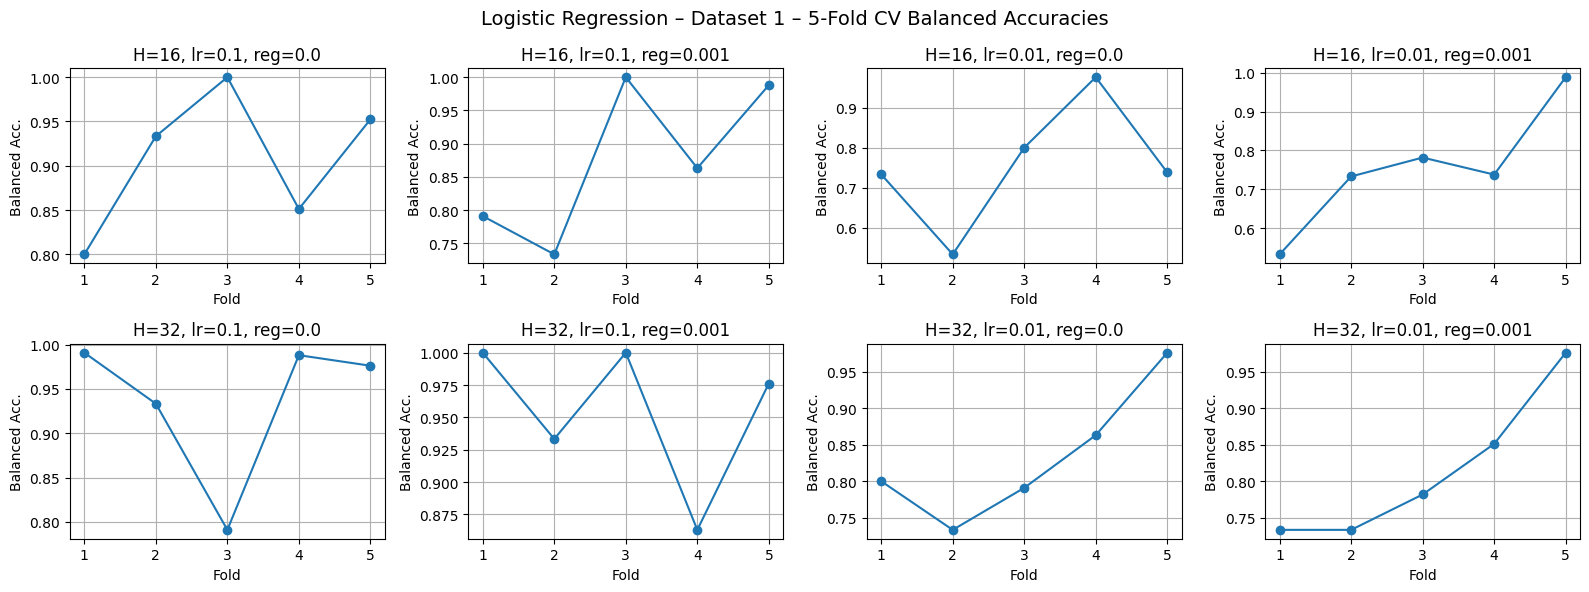


=== MLP Hyperparameter Summary (mean balanced accuracy) ===
[H= 16, lr=0.100, reg=0.0000] → Mean Balanced Acc = 0.9074
[H= 16, lr=0.100, reg=0.0010] → Mean Balanced Acc = 0.8751
[H= 16, lr=0.010, reg=0.0000] → Mean Balanced Acc = 0.7562
[H= 16, lr=0.010, reg=0.0010] → Mean Balanced Acc = 0.7549
[H= 32, lr=0.100, reg=0.0000] → Mean Balanced Acc = 0.9359
[H= 32, lr=0.100, reg=0.0010] → Mean Balanced Acc = 0.9545
[H= 32, lr=0.010, reg=0.0000] → Mean Balanced Acc = 0.8327
[H= 32, lr=0.010, reg=0.0010] → Mean Balanced Acc = 0.8152

Best MLP hyperparameters: H=32, lr=0.1, reg=0.001
Best mean balanced accuracy = 0.9545

Best params for Dataset 1 (MLP): {'hidden': 32, 'lr': 0.1, 'reg': 0.001}

Epoch   0 | Loss = 1.6127
Epoch  20 | Loss = 0.1045
Epoch  40 | Loss = 0.0614
Epoch  60 | Loss = 0.0529
Epoch  80 | Loss = 0.0420
Epoch 100 | Loss = 0.0206
Epoch 120 | Loss = 0.0176
Epoch 140 | Loss = 0.0166
Epoch 160 | Loss = 0.0160
Epoch 180 | Loss = 0.0157
Epoch 200 | Loss = 0.0154
Epoch 220 | Loss =

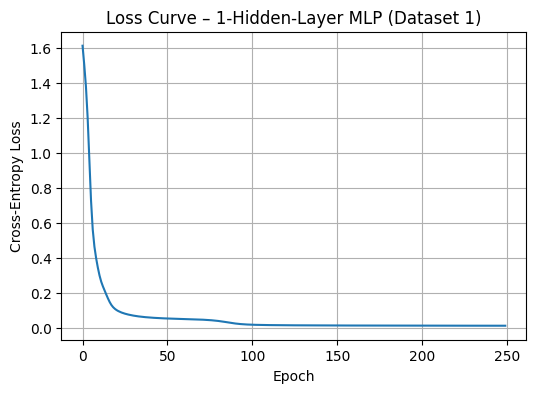


MLP – FINAL VALIDATION REPORT


CONFUSION MATRIX (rows=true, cols=pred):
[[21  0  0  0]
 [ 0  2  0  0]
 [ 0  0  2  0]
 [ 0  0  0  2]]

Per-Class Metrics:
Class | Precision | Recall | F1
    0 |     1.000 |  1.000 | 1.000
    1 |     1.000 |  1.000 | 1.000
    2 |     1.000 |  1.000 | 1.000
    3 |     1.000 |  1.000 | 1.000

Macro Averages:
Macro Precision = 1.000
Macro Recall    = 1.000
Macro F1        = 1.000


In [ ]:
# ============================================================
# MLP PIPELINE FOR ONE DATASET
# ============================================================

i = 1   

# 1. Imputation settings (reuse from previous work)
k_impute_dict = {
    1: None,
    2: None,
    3: imputation_k_results.get(3, None),  # dataset 3 had KNN imputation
    4: None
}

# 2. Preprocess: impute + standardize + zero-based labels
X_train_i, y_train_i, _ = preprocess_dataset(i, k_impute_dict)

# 3. 5-fold CV to pick MLP hyperparameters
best_params_mlp, cv_scores_mlp = mlp_cv(
    X_train_i,
    y_train_i,
    hidden_sizes=(16, 32),           # you can expand later, e.g. (16,32,64)
    learning_rates=(0.1, 0.01),
    regs=(0.0, 0.001),
    epochs=200,
    n_splits=5,
    plot_cv=True
)

print(f"\nBest params for Dataset {i} (MLP): {best_params_mlp}\n")

# 4. Train final model on FULL training set with best hyperparameters
num_classes  = len(np.unique(y_train_i))
num_features = X_train_i.shape[1]

final_mlp = MLP1Hidden(
    num_features=num_features,
    num_hidden=best_params_mlp["hidden"],
    num_classes=num_classes,
    lr=best_params_mlp["lr"],
    reg=best_params_mlp["reg"]
)

loss_history_mlp = final_mlp.fit(
    X_train_i, y_train_i,
    epochs=250,       # you can tweak based on loss curve
    verbose=True
)

# 5. Plot training loss curve
plt.figure(figsize=(6,4))
plt.plot(loss_history_mlp)
plt.title(f"Loss Curve – 1-Hidden-Layer MLP (Dataset {i})")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True)
plt.show()

# 6. Evaluate on a new 80/20 split (fresh, independent of CV folds)
X_tr_chk, y_tr_chk, X_val_chk, y_val_chk = stratified_train_val_split(
    X_train_i, y_train_i, val_ratio=0.2, seed=999
)

pred_val_mlp = final_mlp.predict(X_val_chk)

print("\nMLP – FINAL VALIDATION REPORT\n")
classification_report(y_val_chk, pred_val_mlp)


--- MLP CV: Fold 1/5 ---
Validation class distribution: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2]))
[H= 16, lr=0.100, reg=0.0000] Balanced Acc = 0.8030
[H= 16, lr=0.100, reg=0.0010] Balanced Acc = 0.7727
[H= 16, lr=0.010, reg=0.0000] Balanced Acc = 0.6818
[H= 16, lr=0.010, reg=0.0010] Balanced Acc = 0.6818
[H= 32, lr=0.100, reg=0.0000] Balanced Acc = 0.7576
[H= 32, lr=0.100, reg=0.0010] Balanced Acc = 0.7576
[H= 32, lr=0.010, reg=0.0000] Balanced Acc = 0.7121
[H= 32, lr=0.010, reg=0.0010] Balanced Acc = 0.7121


--- MLP CV: Fold 2/5 ---
Validation class distribution: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([2, 2, 3, 2, 2, 2, 1, 2, 1, 2, 2]))
[H= 16, lr=0.100, reg=0.0000] Balanced Acc = 0.9091
[H= 16, lr=0.100, reg=0.0010] Balanced Acc = 1.0000
[H= 16, lr=0.010, reg=0.0000] Balanced Acc = 0.8636
[H= 16, lr=0.010, reg=0.0010] Balanced Acc = 1.0000
[H= 32, lr=0.100, reg=0.0000] Balanced Acc = 0.8636
[H= 32, lr=0.100,

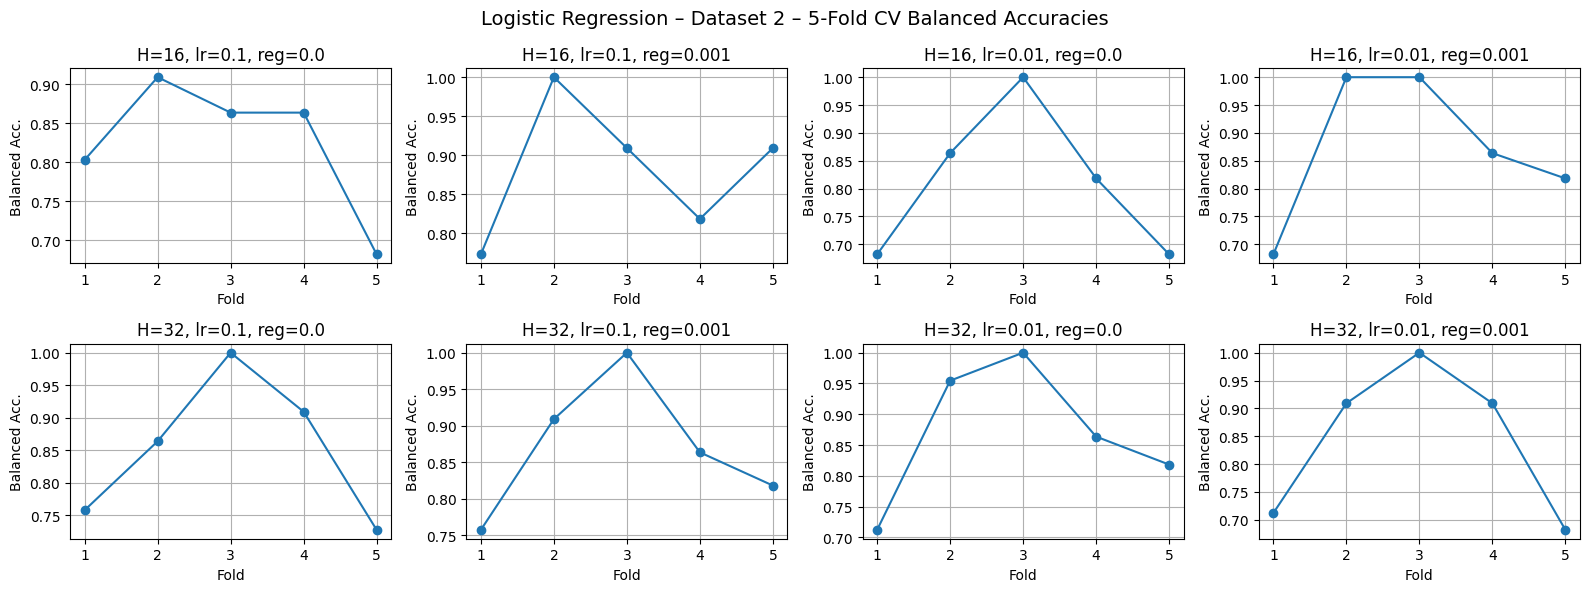


=== MLP Hyperparameter Summary (mean balanced accuracy) ===
[H= 16, lr=0.100, reg=0.0000] → Mean Balanced Acc = 0.8242
[H= 16, lr=0.100, reg=0.0010] → Mean Balanced Acc = 0.8818
[H= 16, lr=0.010, reg=0.0000] → Mean Balanced Acc = 0.8091
[H= 16, lr=0.010, reg=0.0010] → Mean Balanced Acc = 0.8727
[H= 32, lr=0.100, reg=0.0000] → Mean Balanced Acc = 0.8515
[H= 32, lr=0.100, reg=0.0010] → Mean Balanced Acc = 0.8697
[H= 32, lr=0.010, reg=0.0000] → Mean Balanced Acc = 0.8697
[H= 32, lr=0.010, reg=0.0010] → Mean Balanced Acc = 0.8424

Best MLP hyperparameters: H=16, lr=0.1, reg=0.001
Best mean balanced accuracy = 0.8818

Best params for Dataset 2 (MLP): {'hidden': 16, 'lr': 0.1, 'reg': 0.001}

Epoch   0 | Loss = 2.4164
Epoch  20 | Loss = 0.0740
Epoch  40 | Loss = 0.0301
Epoch  60 | Loss = 0.0247
Epoch  80 | Loss = 0.0228
Epoch 100 | Loss = 0.0218
Epoch 120 | Loss = 0.0212
Epoch 140 | Loss = 0.0208
Epoch 160 | Loss = 0.0205
Epoch 180 | Loss = 0.0202
Epoch 200 | Loss = 0.0200
Epoch 220 | Loss =

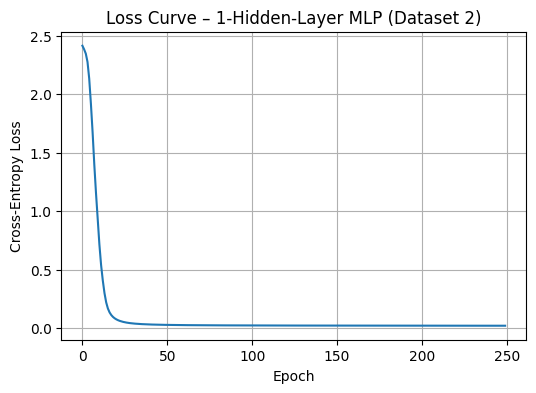


MLP – FINAL VALIDATION REPORT


CONFUSION MATRIX (rows=true, cols=pred):
[[2 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 2 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 1]]

Per-Class Metrics:
Class | Precision | Recall | F1
    0 |     1.000 |  1.000 | 1.000
    1 |     1.000 |  1.000 | 1.000
    2 |     1.000 |  1.000 | 1.000
    3 |     1.000 |  1.000 | 1.000
    4 |     1.000 |  1.000 | 1.000
    5 |     1.000 |  1.000 | 1.000
    6 |     1.000 |  1.000 | 1.000
    7 |     1.000 |  1.000 | 1.000
    8 |     1.000 |  1.000 | 1.000
    9 |     1.000 |  1.000 | 1.000
   10 |     1.000 |  1.000 | 1.000

Macro Averages:
Macro Precision = 1.000
Macro Recall    = 1.000
Macro F1        = 1.000


In [ ]:
# ============================================================
# MLP PIPELINE FOR ONE DATASET
# ============================================================

i = 2   

# 1. Imputation settings (reuse from previous work)
k_impute_dict = {
    1: None,
    2: None,
    3: imputation_k_results.get(3, None),  # dataset 3 had KNN imputation
    4: None
}

# 2. Preprocess: impute + standardize + zero-based labels
X_train_i, y_train_i, _ = preprocess_dataset(i, k_impute_dict)

# 3. 5-fold CV to pick MLP hyperparameters
best_params_mlp, cv_scores_mlp = mlp_cv(
    X_train_i,
    y_train_i,
    hidden_sizes=(16, 32),           # you can expand later, e.g. (16,32,64)
    learning_rates=(0.1, 0.01),
    regs=(0.0, 0.001),
    epochs=200,
    n_splits=5,
    plot_cv=True
)

print(f"\nBest params for Dataset {i} (MLP): {best_params_mlp}\n")

# 4. Train final model on FULL training set with best hyperparameters
num_classes  = len(np.unique(y_train_i))
num_features = X_train_i.shape[1]

final_mlp = MLP1Hidden(
    num_features=num_features,
    num_hidden=best_params_mlp["hidden"],
    num_classes=num_classes,
    lr=best_params_mlp["lr"],
    reg=best_params_mlp["reg"]
)

loss_history_mlp = final_mlp.fit(
    X_train_i, y_train_i,
    epochs=250,       # you can tweak based on loss curve
    verbose=True
)

# 5. Plot training loss curve
plt.figure(figsize=(6,4))
plt.plot(loss_history_mlp)
plt.title(f"Loss Curve – 1-Hidden-Layer MLP (Dataset {i})")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True)
plt.show()

# 6. Evaluate on a new 80/20 split (fresh, independent of CV folds)
X_tr_chk, y_tr_chk, X_val_chk, y_val_chk = stratified_train_val_split(
    X_train_i, y_train_i, val_ratio=0.2, seed=999
)

pred_val_mlp = final_mlp.predict(X_val_chk)

print("\nMLP – FINAL VALIDATION REPORT\n")
classification_report(y_val_chk, pred_val_mlp)


--- MLP CV: Fold 1/5 ---
Validation class distribution: (array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([247, 111,  98, 114,  99, 156, 136, 183, 120]))
[H= 16, lr=0.100, reg=0.0000] Balanced Acc = 0.1917
[H= 16, lr=0.100, reg=0.0010] Balanced Acc = 0.1912
[H= 16, lr=0.010, reg=0.0000] Balanced Acc = 0.1111
[H= 16, lr=0.010, reg=0.0010] Balanced Acc = 0.1111
[H= 32, lr=0.100, reg=0.0000] Balanced Acc = 0.1915
[H= 32, lr=0.100, reg=0.0010] Balanced Acc = 0.1922
[H= 32, lr=0.010, reg=0.0000] Balanced Acc = 0.1111
[H= 32, lr=0.010, reg=0.0010] Balanced Acc = 0.1111


--- MLP CV: Fold 2/5 ---
Validation class distribution: (array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([247, 111,  98, 113,  99, 156, 136, 183, 119]))
[H= 16, lr=0.100, reg=0.0000] Balanced Acc = 0.1973
[H= 16, lr=0.100, reg=0.0010] Balanced Acc = 0.1985
[H= 16, lr=0.010, reg=0.0000] Balanced Acc = 0.1111
[H= 16, lr=0.010, reg=0.0010] Balanced Acc = 0.1111
[H= 32, lr=0.100, reg=0.0000] Balanced Acc = 0.1987
[H= 32, lr=0.100, reg=0.001

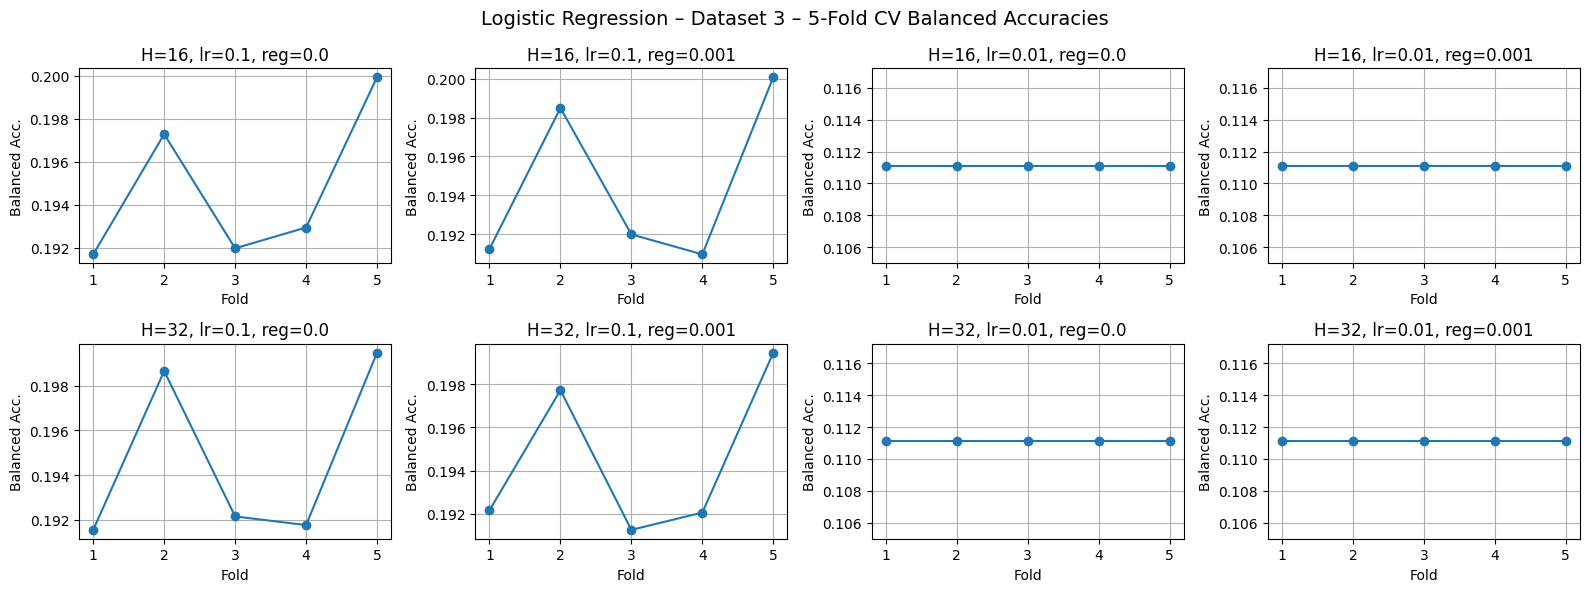


=== MLP Hyperparameter Summary (mean balanced accuracy) ===
[H= 16, lr=0.100, reg=0.0000] → Mean Balanced Acc = 0.1948
[H= 16, lr=0.100, reg=0.0010] → Mean Balanced Acc = 0.1946
[H= 16, lr=0.010, reg=0.0000] → Mean Balanced Acc = 0.1111
[H= 16, lr=0.010, reg=0.0010] → Mean Balanced Acc = 0.1111
[H= 32, lr=0.100, reg=0.0000] → Mean Balanced Acc = 0.1947
[H= 32, lr=0.100, reg=0.0010] → Mean Balanced Acc = 0.1945
[H= 32, lr=0.010, reg=0.0000] → Mean Balanced Acc = 0.1111
[H= 32, lr=0.010, reg=0.0010] → Mean Balanced Acc = 0.1111

Best MLP hyperparameters: H=16, lr=0.1, reg=0.0
Best mean balanced accuracy = 0.1948

Best params for Dataset 3 (MLP): {'hidden': 16, 'lr': 0.1, 'reg': 0.0}

Epoch   0 | Loss = 2.1971
Epoch  20 | Loss = 2.1771
Epoch  40 | Loss = 2.1631
Epoch  60 | Loss = 2.1491
Epoch  80 | Loss = 2.1242
Epoch 100 | Loss = 2.0768
Epoch 120 | Loss = 2.0280
Epoch 140 | Loss = 1.9949
Epoch 160 | Loss = 1.9650
Epoch 180 | Loss = 1.9357
Epoch 200 | Loss = 1.9100
Epoch 220 | Loss = 1.8

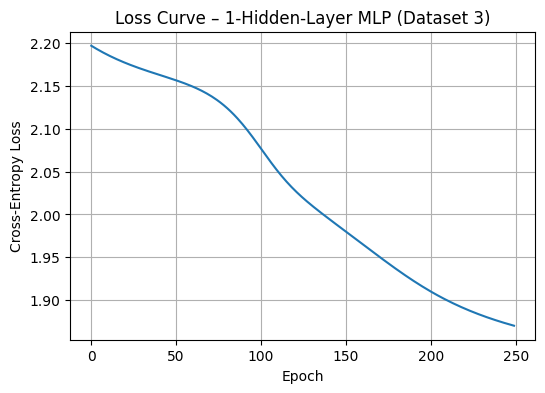


MLP – FINAL VALIDATION REPORT


CONFUSION MATRIX (rows=true, cols=pred):
[[228   0   0   0   0   3   0  16   0]
 [ 78   0   0   0   0   4   0  28   0]
 [ 59   0   0   0   0   4   0  34   0]
 [ 51   0   0   0   0   2   0  60   0]
 [ 29   0   0   0   0  11   0  59   0]
 [ 33   0   0   0   0   9   0 113   0]
 [ 26   0   0   0   0   4   0 105   0]
 [ 29   0   0   0   0   1   0 152   0]
 [ 27   0   0   0   0   0   0  92   0]]

Per-Class Metrics:
Class | Precision | Recall | F1
    0 |     0.407 |  0.923 | 0.565
    1 |     0.000 |  0.000 | 0.000
    2 |     0.000 |  0.000 | 0.000
    3 |     0.000 |  0.000 | 0.000
    4 |     0.000 |  0.000 | 0.000
    5 |     0.237 |  0.058 | 0.093
    6 |     0.000 |  0.000 | 0.000
    7 |     0.231 |  0.835 | 0.361
    8 |     0.000 |  0.000 | 0.000

Macro Averages:
Macro Precision = 0.097
Macro Recall    = 0.202
Macro F1        = 0.113


In [42]:
# ============================================================
# MLP PIPELINE FOR ONE DATASET
# ============================================================

i = 3   

# 1. Imputation settings (reuse from previous work)
k_impute_dict = {
    1: None,
    2: None,
    3: imputation_k_results.get(3, None),  # dataset 3 had KNN imputation
    4: None
}

# 2. Preprocess: impute + standardize + zero-based labels
X_train_i, y_train_i, _ = preprocess_dataset(i, k_impute_dict)

# 3. 5-fold CV to pick MLP hyperparameters
best_params_mlp, cv_scores_mlp = mlp_cv(
    X_train_i,
    y_train_i,
    hidden_sizes=(16, 32),           # you can expand later, e.g. (16,32,64)
    learning_rates=(0.1, 0.01),
    regs=(0.0, 0.001),
    epochs=200,
    n_splits=5,
    plot_cv=True
)

print(f"\nBest params for Dataset {i} (MLP): {best_params_mlp}\n")

# 4. Train final model on FULL training set with best hyperparameters
num_classes  = len(np.unique(y_train_i))
num_features = X_train_i.shape[1]

final_mlp = MLP1Hidden(
    num_features=num_features,
    num_hidden=best_params_mlp["hidden"],
    num_classes=num_classes,
    lr=best_params_mlp["lr"],
    reg=best_params_mlp["reg"]
)

loss_history_mlp = final_mlp.fit(
    X_train_i, y_train_i,
    epochs=250,       # you can tweak based on loss curve
    verbose=True
)

# 5. Plot training loss curve
plt.figure(figsize=(6,4))
plt.plot(loss_history_mlp)
plt.title(f"Loss Curve – 1-Hidden-Layer MLP (Dataset {i})")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True)
plt.show()

# 6. Evaluate on a new 80/20 split (fresh, independent of CV folds)
X_tr_chk, y_tr_chk, X_val_chk, y_val_chk = stratified_train_val_split(
    X_train_i, y_train_i, val_ratio=0.2, seed=999
)

pred_val_mlp = final_mlp.predict(X_val_chk)

print("\nMLP – FINAL VALIDATION REPORT\n")
classification_report(y_val_chk, pred_val_mlp)


--- MLP CV: Fold 1/5 ---
Validation class distribution: (array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([58, 55, 54, 59, 56, 58, 58, 60, 54]))
[H= 16, lr=0.100, reg=0.0000] Balanced Acc = 0.5577
[H= 16, lr=0.100, reg=0.0010] Balanced Acc = 0.5422
[H= 16, lr=0.010, reg=0.0000] Balanced Acc = 0.2089
[H= 16, lr=0.010, reg=0.0010] Balanced Acc = 0.1923
[H= 32, lr=0.100, reg=0.0000] Balanced Acc = 0.6570
[H= 32, lr=0.100, reg=0.0010] Balanced Acc = 0.6211
[H= 32, lr=0.010, reg=0.0000] Balanced Acc = 0.1712
[H= 32, lr=0.010, reg=0.0010] Balanced Acc = 0.2377


--- MLP CV: Fold 2/5 ---
Validation class distribution: (array([0, 1, 2, 3, 4, 5, 6, 7, 8]), array([58, 55, 54, 59, 56, 58, 58, 60, 54]))
[H= 16, lr=0.100, reg=0.0000] Balanced Acc = 0.6062
[H= 16, lr=0.100, reg=0.0010] Balanced Acc = 0.6450
[H= 16, lr=0.010, reg=0.0000] Balanced Acc = 0.1358
[H= 16, lr=0.010, reg=0.0010] Balanced Acc = 0.2033
[H= 32, lr=0.100, reg=0.0000] Balanced Acc = 0.6916
[H= 32, lr=0.100, reg=0.0010] Balanced Acc = 

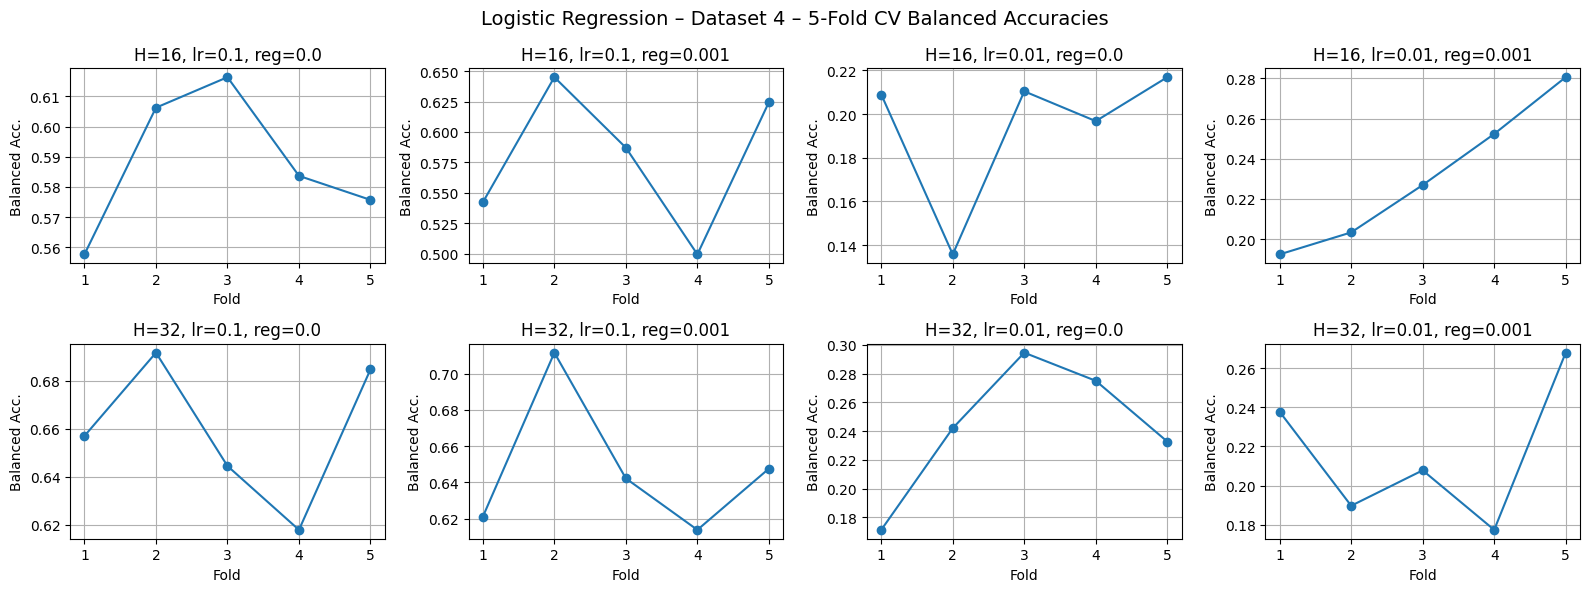


=== MLP Hyperparameter Summary (mean balanced accuracy) ===
[H= 16, lr=0.100, reg=0.0000] → Mean Balanced Acc = 0.5879
[H= 16, lr=0.100, reg=0.0010] → Mean Balanced Acc = 0.5796
[H= 16, lr=0.010, reg=0.0000] → Mean Balanced Acc = 0.1937
[H= 16, lr=0.010, reg=0.0010] → Mean Balanced Acc = 0.2311
[H= 32, lr=0.100, reg=0.0000] → Mean Balanced Acc = 0.6591
[H= 32, lr=0.100, reg=0.0010] → Mean Balanced Acc = 0.6473
[H= 32, lr=0.010, reg=0.0000] → Mean Balanced Acc = 0.2431
[H= 32, lr=0.010, reg=0.0010] → Mean Balanced Acc = 0.2161

Best MLP hyperparameters: H=32, lr=0.1, reg=0.0
Best mean balanced accuracy = 0.6591

Best params for Dataset 4 (MLP): {'hidden': 32, 'lr': 0.1, 'reg': 0.0}

Epoch   0 | Loss = 2.1969
Epoch  20 | Loss = 2.1902
Epoch  40 | Loss = 2.1675
Epoch  60 | Loss = 2.0824
Epoch  80 | Loss = 1.8942
Epoch 100 | Loss = 1.6869
Epoch 120 | Loss = 1.4934
Epoch 140 | Loss = 1.3187
Epoch 160 | Loss = 1.1706
Epoch 180 | Loss = 1.0452
Epoch 200 | Loss = 0.9375
Epoch 220 | Loss = 0.8

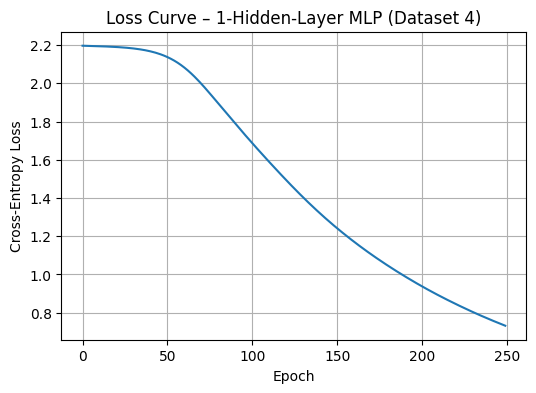


MLP – FINAL VALIDATION REPORT


CONFUSION MATRIX (rows=true, cols=pred):
[[43  1  0 12  0  0  0  0  1]
 [ 9 38  3  2  0  0  1  0  2]
 [ 1  2 43  1  4  0  1  1  1]
 [ 1  0  0 55  2  0  0  0  0]
 [ 1  0  2 10 31  5  5  0  1]
 [ 1  0  0  0 11 43  0  0  2]
 [ 0  1  0  0  0  0 51  4  1]
 [ 0  0  0  0  0  1  1 56  1]
 [ 0  0  0  0  0  2  2  5 45]]

Per-Class Metrics:
Class | Precision | Recall | F1
    0 |     0.768 |  0.754 | 0.761
    1 |     0.905 |  0.691 | 0.784
    2 |     0.896 |  0.796 | 0.843
    3 |     0.687 |  0.948 | 0.797
    4 |     0.646 |  0.564 | 0.602
    5 |     0.843 |  0.754 | 0.796
    6 |     0.836 |  0.895 | 0.864
    7 |     0.848 |  0.949 | 0.896
    8 |     0.833 |  0.833 | 0.833

Macro Averages:
Macro Precision = 0.807
Macro Recall    = 0.798
Macro F1        = 0.797


In [43]:
# ============================================================
# MLP PIPELINE FOR ONE DATASET
# ============================================================

i = 4  

# 1. Imputation settings (reuse from previous work)
k_impute_dict = {
    1: None,
    2: None,
    3: imputation_k_results.get(3, None),  # dataset 3 had KNN imputation
    4: None
}

# 2. Preprocess: impute + standardize + zero-based labels
X_train_i, y_train_i, _ = preprocess_dataset(i, k_impute_dict)

# 3. 5-fold CV to pick MLP hyperparameters
best_params_mlp, cv_scores_mlp = mlp_cv(
    X_train_i,
    y_train_i,
    hidden_sizes=(16, 32),           # you can expand later, e.g. (16,32,64)
    learning_rates=(0.1, 0.01),
    regs=(0.0, 0.001),
    epochs=200,
    n_splits=5,
    plot_cv=True
)

print(f"\nBest params for Dataset {i} (MLP): {best_params_mlp}\n")

# 4. Train final model on FULL training set with best hyperparameters
num_classes  = len(np.unique(y_train_i))
num_features = X_train_i.shape[1]

final_mlp = MLP1Hidden(
    num_features=num_features,
    num_hidden=best_params_mlp["hidden"],
    num_classes=num_classes,
    lr=best_params_mlp["lr"],
    reg=best_params_mlp["reg"]
)

loss_history_mlp = final_mlp.fit(
    X_train_i, y_train_i,
    epochs=250,       # you can tweak based on loss curve
    verbose=True
)

# 5. Plot training loss curve
plt.figure(figsize=(6,4))
plt.plot(loss_history_mlp)
plt.title(f"Loss Curve – 1-Hidden-Layer MLP (Dataset {i})")
plt.xlabel("Epoch")
plt.ylabel("Cross-Entropy Loss")
plt.grid(True)
plt.show()

# 6. Evaluate on a new 80/20 split (fresh, independent of CV folds)
X_tr_chk, y_tr_chk, X_val_chk, y_val_chk = stratified_train_val_split(
    X_train_i, y_train_i, val_ratio=0.2, seed=999
)

pred_val_mlp = final_mlp.predict(X_val_chk)

print("\nMLP – FINAL VALIDATION REPORT\n")
classification_report(y_val_chk, pred_val_mlp)

Since MLP performed much better than other algorithms (KNN and Logistic regression), therefore we're going to use it for TestData1.txt and TestData2.txt

In [47]:
# ============================================================
# FINAL MLP PREDICTIONS FOR DATASET 1
# ============================================================

i = 1
print(f"\n=== Final MLP Pipeline for Dataset {i} ===")

# Imputation config
k_impute_dict = {
    1: None,
    2: None,
    3: imputation_k_results.get(3, None),
    4: None
}

# 1. Preprocess (impute + standardize + zero-base labels)
X_train_1, y_train_1, X_test_1 = preprocess_dataset(i, k_impute_dict)

# 2. Hyperparameter selection
best_params_1, _ = mlp_cv(
    X_train_1, y_train_1,
    hidden_sizes=(16, 32),
    learning_rates=(0.1, 0.01),
    regs=(0.0, 0.001),
    epochs=200,
    n_splits=5,
    plot_cv=False
)

print("Best params for Dataset 1:", best_params_1)

# 3. Train final model
num_classes = len(np.unique(y_train_1))
num_features = X_train_1.shape[1]

mlp_1 = MLP1Hidden(
    num_features=num_features,
    num_hidden=best_params_1["hidden"],
    num_classes=num_classes,
    lr=best_params_1["lr"],
    reg=best_params_1["reg"]
)

mlp_1.fit(X_train_1, y_train_1, epochs=250, verbose=True)

# 4. Predict test labels (zero-based)
pred_test_1_zero = mlp_1.predict(X_test_1)

# 5. Convert back to ORIGINAL labels
_, y_raw_1, _ = load_classification(1)
orig_labels_1 = np.unique(y_raw_1.astype(int))
pred_test_1 = orig_labels_1[pred_test_1_zero]

# 6. Save output
out_path_1 = RESULTS / "MadjitovClassification1.txt"
np.savetxt(out_path_1, pred_test_1.astype(int), fmt="%d")

print("Saved:", out_path_1)


=== Final MLP Pipeline for Dataset 1 ===

--- MLP CV: Fold 1/5 ---
Validation class distribution: (array([0, 1, 2, 3, 4]), array([22,  3,  3,  3,  1]))
[H= 16, lr=0.100, reg=0.0000] Balanced Acc = 0.9909
[H= 16, lr=0.100, reg=0.0010] Balanced Acc = 0.8000
[H= 16, lr=0.010, reg=0.0000] Balanced Acc = 0.6000
[H= 16, lr=0.010, reg=0.0010] Balanced Acc = 0.7909
[H= 32, lr=0.100, reg=0.0000] Balanced Acc = 1.0000
[H= 32, lr=0.100, reg=0.0010] Balanced Acc = 1.0000
[H= 32, lr=0.010, reg=0.0000] Balanced Acc = 0.8000
[H= 32, lr=0.010, reg=0.0010] Balanced Acc = 0.8000


--- MLP CV: Fold 2/5 ---
Validation class distribution: (array([0, 1, 2, 3, 4]), array([22,  3,  2,  3,  1]))
[H= 16, lr=0.100, reg=0.0000] Balanced Acc = 0.7333
[H= 16, lr=0.100, reg=0.0010] Balanced Acc = 0.7333
[H= 16, lr=0.010, reg=0.0000] Balanced Acc = 0.5333
[H= 16, lr=0.010, reg=0.0010] Balanced Acc = 0.7333
[H= 32, lr=0.100, reg=0.0000] Balanced Acc = 0.9333
[H= 32, lr=0.100, reg=0.0010] Balanced Acc = 0.7333
[H= 32,

In [48]:
# ============================================================
# FINAL MLP PREDICTIONS FOR DATASET 2
# ============================================================

i = 2
print(f"\n=== Final MLP Pipeline for Dataset {i} ===")

# Same imputation config
k_impute_dict = {
    1: None,
    2: None,
    3: imputation_k_results.get(3, None),
    4: None
}

# 1. Preprocess
X_train_2, y_train_2, X_test_2 = preprocess_dataset(i, k_impute_dict)

# 2. Hyperparameter selection
best_params_2, _ = mlp_cv(
    X_train_2, y_train_2,
    hidden_sizes=(16, 32),
    learning_rates=(0.1, 0.01),
    regs=(0.0, 0.001),
    epochs=200,
    n_splits=5,
    plot_cv=False
)

print("Best params for Dataset 2:", best_params_2)

# 3. Train final model
num_classes = len(np.unique(y_train_2))
num_features = X_train_2.shape[1]

mlp_2 = MLP1Hidden(
    num_features=num_features,
    num_hidden=best_params_2["hidden"],
    num_classes=num_classes,
    lr=best_params_2["lr"],
    reg=best_params_2["reg"]
)

mlp_2.fit(X_train_2, y_train_2, epochs=250, verbose=True)

# 4. Predict test labels
pred_test_2_zero = mlp_2.predict(X_test_2)

# 5. Convert back to original labels
_, y_raw_2, _ = load_classification(2)
orig_labels_2 = np.unique(y_raw_2.astype(int))
pred_test_2 = orig_labels_2[pred_test_2_zero]

# 6. Save output
out_path_2 = RESULTS / "MadjitovClassification2.txt"
np.savetxt(out_path_2, pred_test_2.astype(int), fmt="%d")

print("Saved:", out_path_2)


=== Final MLP Pipeline for Dataset 2 ===

--- MLP CV: Fold 1/5 ---
Validation class distribution: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([2, 2, 3, 3, 3, 2, 2, 2, 2, 2, 2]))
[H= 16, lr=0.100, reg=0.0000] Balanced Acc = 0.8030
[H= 16, lr=0.100, reg=0.0010] Balanced Acc = 0.8030
[H= 16, lr=0.010, reg=0.0000] Balanced Acc = 0.6818
[H= 16, lr=0.010, reg=0.0010] Balanced Acc = 0.7424
[H= 32, lr=0.100, reg=0.0000] Balanced Acc = 0.7576
[H= 32, lr=0.100, reg=0.0010] Balanced Acc = 0.8030
[H= 32, lr=0.010, reg=0.0000] Balanced Acc = 0.7424
[H= 32, lr=0.010, reg=0.0010] Balanced Acc = 0.7727


--- MLP CV: Fold 2/5 ---
Validation class distribution: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([2, 2, 3, 2, 2, 2, 1, 2, 1, 2, 2]))
[H= 16, lr=0.100, reg=0.0000] Balanced Acc = 0.8182
[H= 16, lr=0.100, reg=0.0010] Balanced Acc = 0.9545
[H= 16, lr=0.010, reg=0.0000] Balanced Acc = 0.8182
[H= 16, lr=0.010, reg=0.0010] Balanced Acc = 0.7727
[H= 32, lr=0.100, reg=0.000